In [610]:
import pandas as pd
from sklearn.metrics import  f1_score, accuracy_score
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from IPython.display import clear_output
from sklearn.utils.class_weight import compute_class_weight

from app import cat_features, pca_pipeline, lag_features

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [611]:
pd.set_option('display.max_columns', None) 

In [612]:
data = pd.read_csv('df_general.csv')
data[lag_features] = data[lag_features].fillna(999)

In [613]:
data.fillna(0, inplace=True)

In [614]:
train = data[data['gameweek_compSeason_label'] != 2023]
test = data[data['gameweek_compSeason_label'] == 2023]

In [615]:
X_train = train.drop('team_1_hue', axis=1)
y_train = train['team_1_hue']

cat_cols = cat_features(X_train)
num_cols = list(set(X_train.columns.tolist()) - set(cat_cols))

X_test = test.drop('team_1_hue', axis=1)
y_test = test['team_1_hue']

In [616]:
X_train.shape, X_test.shape

((3192, 1196), (180, 1196))

In [617]:
X_train, pipeline = pca_pipeline(X_train, y_train, cat_cols, num_cols, n_components=20 ,pca=True)

In [618]:
X_train

array([[-4.95875494e+02,  1.69138819e+03,  2.38560137e+03, ...,
        -1.27471322e+00,  2.04870730e+00,  2.26456221e+00],
       [-4.98870888e+02,  1.69123660e+03,  2.38553617e+03, ...,
        -5.44389862e-01,  1.27947120e+00,  4.44591644e-01],
       [-5.05859976e+02,  1.69087925e+03,  2.38538623e+03, ...,
        -1.17791356e+00,  1.70228896e+00,  1.88161827e+00],
       ...,
       [-3.43226620e+02, -4.80789947e+02,  5.60825882e+01, ...,
         4.14720304e+00, -5.42350434e-01,  1.15166749e+00],
       [-3.50245398e+02, -4.80453779e+02,  5.55917029e+01, ...,
         4.61620294e+00,  3.97256923e+00, -6.49946412e-01],
       [-3.44123843e+02, -4.82599221e+02,  5.52085877e+01, ...,
         4.02004220e+00,  9.40782281e-01, -8.78503708e-01]])

In [619]:
X_test = pipeline.transform(X_test)
X_test

array([[-3.45137579e+02, -4.82391819e+02,  5.59594314e+01, ...,
         5.33318691e+00,  4.82567474e+00,  6.40909604e-01],
       [-3.60759562e+02,  1.82420465e+02, -3.40748442e+02, ...,
         5.65348667e+00, -3.75154875e-01,  3.91975308e+00],
       [ 5.20512963e+02, -4.38428455e+02,  7.36834395e+01, ...,
         3.61825925e+00, -1.05897938e+00,  2.65037478e-01],
       ...,
       [-3.45208932e+02, -4.80275101e+02,  5.47686833e+01, ...,
         5.84444412e+00,  1.03774637e+00,  3.85059260e+00],
       [-3.61172030e+02, -4.82118446e+02,  5.51560787e+01, ...,
         4.88887202e+00,  5.95944926e-02, -1.63057366e-01],
       [ 1.60765173e+03, -3.81253600e+02,  9.92142973e+01, ...,
         3.56221913e+00,  1.37600283e+00,  2.86611206e+00]])

In [620]:
X_train.shape, X_test.shape

((3192, 20), (180, 20))

In [621]:
!nvidia-smi

Mon Jun 17 09:38:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0  On |                  Off |
| 30%   41C    P2             105W / 450W |   4931MiB / 24564MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [622]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):

    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('F1 macro')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True, device=device):

    torch.manual_seed(42)
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    for epoch in range(1, num_epochs + 1):
        model.train()

        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'metric': metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
                
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'metric': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]


        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f'Validation: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]

In [623]:
class BaseLineModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaseLineModel, self).__init__()
        # Первый слой
        self.block1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Второй слой
        self.block2 = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.BatchNorm1d(input_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
      
        # Третий слой
        self.block3 = nn.Sequential(
            nn.Linear(input_size, input_size//4),
            nn.BatchNorm1d(input_size//4),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Выход
        self.output_block = nn.Sequential(
            nn.Linear(input_size//4, output_size),
            nn.BatchNorm1d(output_size),
            nn.Softmax(dim=1)  
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.output_block(out)
        return out

In [624]:
input_size = X_train.shape[1]
hidden_size = input_size * 4
output_size = 3
batch_size = 256
num_epochs = 160

In [625]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(list(y_train), dtype=torch.int16)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(list(y_test), dtype=torch.int16)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [626]:
model = BaseLineModel(input_size, hidden_size, output_size).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
metric = lambda outputs, targets: f1_score(outputs.argmax(dim=1), targets, average='macro')

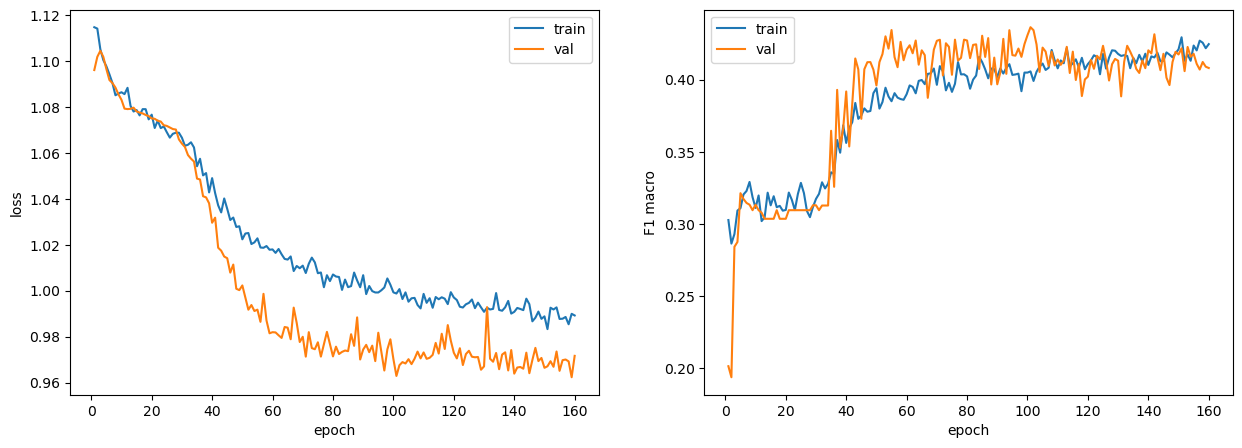

Validation: 0.408


In [627]:
train_acc, val_acc = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                                         num_epochs=num_epochs, verbose=True, device=device)

In [628]:
f1_macro = f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='macro')
f1_weight = f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='weighted')
accuracy = accuracy_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy())

In [629]:
print(f"f1_macro: {f1_macro:.2f}\nf1_weight: {f1_weight:.2f}\naccuracy: {accuracy:.2f}")

f1_macro: 0.41
f1_weight: 0.50
accuracy: 0.56


## Class weight

In [630]:
y_train_np = y_train_tensor.numpy()
class_weights = compute_class_weight(class_weight='balanced', classes=torch.unique(y_train_tensor).numpy(), y=y_train_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights_tensor

tensor([1.0462, 0.7368, 1.4555])

In [631]:
model = BaseLineModel(input_size, hidden_size, output_size).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

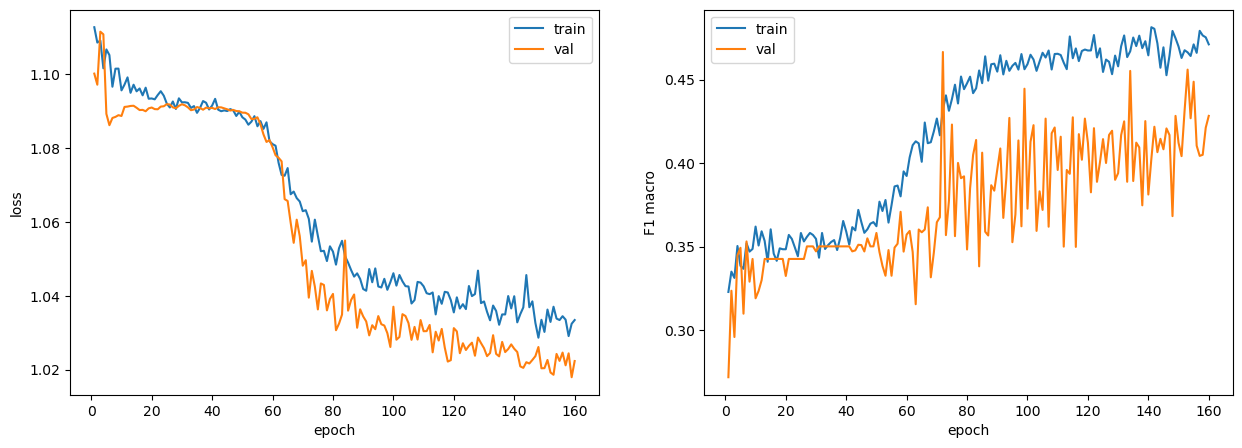

Validation: 0.428


In [632]:
train_acc, val_acc = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                                         num_epochs=num_epochs, verbose=True, device=device)

In [633]:
f1_macro = f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='macro')
f1_weight = f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='weighted')
accuracy = accuracy_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy())

In [634]:
print(f"f1_macro: {f1_macro:.2f}\nf1_weight: {f1_weight:.2f}\naccuracy: {accuracy:.2f}")

f1_macro: 0.43
f1_weight: 0.45
accuracy: 0.48


## TimeSplit

In [635]:
data

match_id  gameweek_gameweek  gameweek_compSeason_label  \
0         9611                  1                       2014   
1         9612                  1                       2014   
2         9613                  1                       2014   
3         9614                  1                       2014   
4         9615                  1                       2014   
...        ...                ...                        ...   
3367     93539                 22                       2023   
3368     93540                 22                       2023   
3369     93545                 23                       2023   
3370     93547                 23                       2023   
3371     93550                 23                       2023   

        teams_team_1_name  teams_team_2_name  team_1_hue month day_week  hour  \
0                 Arsenal     Crystal Palace           1   Aug      Sat    17   
1          Leicester City            Everton           2   Aug      Sat    15   
2       Manchester United       Swansea City           0   Aug      Sat    12   
3     Queens Park Rangers          Hull City           0   Aug      Sat    15   
4              Stoke City        Aston Villa           0   Aug      Sat    15   
...                   ...                ...         ...   ...      ...   ...   
3367            Liverpool            Chelsea           1   Jan      Wed    20   
3368      Manchester City            Burnley           1   Jan      Wed    19   
3369              Burnley             Fulham           2   Feb      Sat    15   
3370              Everton  Tottenham Hotspur           2   Feb      Sat    12   
3371     Sheffield United        Aston Villa           0   Feb      Sat    17   

      ground_id  _accurate_back_zone_pass_team_1  \
0            52                      7925.444444   
1            49                      6395.666667   
2            42                      7671.666667   
3            46                      4135.000000   
4           435                      5308.250000   
...         ...                              ...   
3367        901                      8856.333333   
3368        457                      9053.555556   
3369         47                      4202.000000   
3370         31                      6304.777778   
3371       2003                      4923.500000   

      _accurate_chipped_pass_team_1  _accurate_corners_intobox_team_1  \
0                        693.777778                         51.222222   
1                        663.222222                         46.666667   
2                        724.222222                         49.000000   
3                        574.000000                         67.000000   
4                        590.500000                         53.000000   
...                             ...                               ...   
3367                     844.333333                         62.111111   
3368                     732.666667                         72.555556   
3369                     598.428571                         52.285714   
3370                     615.222222                         52.111111   
3371                     555.500000                         48.500000   

      _accurate_cross_team_1  _accurate_cross_nocorner_team_1  \
0                 150.333333                       101.111111   
1                 146.777778                       102.777778   
2                 153.444444                       107.000000   
3                 182.000000                       116.000000   
4                 157.750000                       106.250000   
...                      ...                              ...   
3367              180.222222                       119.888889   
3368              173.000000                       105.777778   
3369              171.428571                       120.000000   
3370              164.666667                       113.333333   
3371              161.500000                   

In [636]:
from sklearn.model_selection import TimeSeriesSplit
preds, tests, proba = [], [], []
tscv = TimeSeriesSplit(n_splits=19, test_size=20)

for train_index, test_index in tscv.split(data.drop('team_1_hue', axis=1), data['team_1_hue']):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    X_train = train.drop('team_1_hue', axis=1)
    y_train = train['team_1_hue']

    cat_cols = cat_features(X_train)
    num_cols = list(set(X_train.columns.tolist()) - set(cat_cols))

    X_test = test.drop('team_1_hue', axis=1)
    y_test = test['team_1_hue']

    X_train, pipeline = pca_pipeline(X_train, y_train, cat_cols, num_cols, n_components=20 ,pca=True)
    X_test = pipeline.transform(X_test)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(list(y_train), dtype=torch.int16)
    X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_val_tensor = torch.tensor(list(y_test), dtype=torch.int16)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    y_train_np = y_train_tensor.numpy()
    class_weights = compute_class_weight(class_weight='balanced', classes=torch.unique(y_train_tensor).numpy(), y=y_train_np)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    class_weights_tensor

    model = BaseLineModel(input_size, hidden_size, output_size).to(device)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_acc, val_acc = train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                                            num_epochs=num_epochs, verbose=False, device=device)

    f1_macro = f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='macro')
    f1_weight = f1_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy(), average='weighted')
    accuracy = accuracy_score(y_val_tensor, model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().numpy())
    
    print(f"f1_macro: {f1_macro:.2f}\n")

    tests.extend(y_val_tensor.cpu().detach().tolist())
    preds.extend(model(X_val_tensor.to(device)).argmax(dim=1).cpu().detach().tolist())

f1_macro: 0.45

f1_macro: 0.33

f1_macro: 0.33

f1_macro: 0.40

f1_macro: 0.37

f1_macro: 0.29

f1_macro: 0.30

f1_macro: 0.33

f1_macro: 0.56

f1_macro: 0.33

f1_macro: 0.30

f1_macro: 0.40

f1_macro: 0.65

f1_macro: 0.56

f1_macro: 0.52

f1_macro: 0.40

f1_macro: 0.35

f1_macro: 0.40

f1_macro: 0.67



In [637]:
f1_macro = f1_score(tests, preds, average='macro')
f1_weight = f1_score(tests, preds, average='weighted')
accuracy = accuracy_score(tests, preds)

print(f"f1_macro: {f1_macro:.2f}\nf1_weight: {f1_weight:.2f}\naccuracy: {accuracy:.2f}\n")

f1_macro: 0.44
f1_weight: 0.47
accuracy: 0.47

